In [13]:
#Import 
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np

#import data
from biom import load_table
from skbio.stats import subsample_counts

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from DEICODE.utils import plot_pcoa

#MOCK data generation
from gneiss.util import match
from gneiss.sort import niche_sort
from DEICODE.utils import block_diagonal_gaus
from DEICODE.utils import build_block_model

#Model Evaluation
from sklearn.metrics import mean_squared_error
from DEICODE.utils import mean_KL
from DEICODE.utils import minimize_model

#completion methods
from DEICODE.optspace import OptSpace
from DEICODE.GaPNMF import GaPNMF
from fancyimpute import KNN,SoftImpute,IterativeSVD,MatrixFactorization

#compostional transform
from skbio.stats.composition import clr

# make it look nice
sns.set(font="monospace")
#make the text readable
from IPython.core.display import HTML
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-white')
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-paper')
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.2em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")
%matplotlib inline


### The Keyboard Dataset (Qiita ID 232)

In a study done by Noah Fierer (University of Colorado) they discover that

    "diversity of skin-associated bacterial communities is far higher than previously recognized, with a high degree of inter-individual variability in the composition of bacterial communities." 

The study goes on describing the amazing forensic implications of matching a person's skin microbial community to a recently interacted surface. However, in the process a prime example of a low-rank microbial dataset was created and has recently become a favorite benchmarking dataset for new tools. Here we will explain and investigate the structure of the microbial communities between the different people samples. Then we will fit a model on this data to  benchmark a new tool called matrix completion that is applicable to datasets with distinct clusters such as this one. 



In [2]:
# import observation data
in_biom='data/benchmarking/keyboard.biom' #import biom file
table = load_table(in_biom)
read_filter_s = lambda val, id_, md: sum(val) > 0
read_filter_f = lambda val, id_, md: sum(val) > 0
table=table.filter(read_filter_s, axis='sample')
table=table.filter(read_filter_f, axis='observation')
otutabledf=table.to_dataframe()
otutabledf=otutabledf.T
otutabledf.drop_duplicates(inplace=True)

# Get OTU to taxa match
taxonomy=table.metadata_to_dataframe('observation')
taxonomy.columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species']
taxonomy['taxonomy'] = taxonomy[taxonomy.columns].apply(lambda x: ';'.join(x), axis=1)

#mapping import 
map_file='data/benchmarking/keyboard.txt' #import metadata
mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)
mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
mappingdf.index=list(map(str,mappingdf.index))
mappingdf=mappingdf.astype(str)
mappingdf=mappingdf[~mappingdf.index.duplicated(keep='first')]

#match the tables
otutabledf,mappingdf=match(otutabledf,mappingdf[mappingdf['host_subject_id'].isin(['M2','M3','M9'])])

otutabledf=otutabledf.T[otutabledf.sum()>0].T
otutabledf=otutabledf[otutabledf.T.sum()>0]
otutabledf.columns=[str(x) for x in otutabledf.columns]

sorting_map={'M9':2,'M2':3,'M3':1}

mappingdf['host_num']=[int(sorting_map[x]) for x in mappingdf['host_subject_id']]
mappingdf=mappingdf.apply(pd.to_numeric, errors='ignore')

#sort by niche 
observed_table = niche_sort(otutabledf, mappingdf['host_num'])
mappingdf=mappingdf.T[observed_table.index].T
otutabledf=observed_table.copy()

First, we will look at how the microbial composition changes between people sampled (n=3) and how if properly sequenced (too a deep enough depth) they form three distinct clusters. We also show here that if the samples are under sequenced they begin to merge into one non-distinct cluster. The separation between the clusters can be thought of as effect size and the number of distinct clusters the rank. 

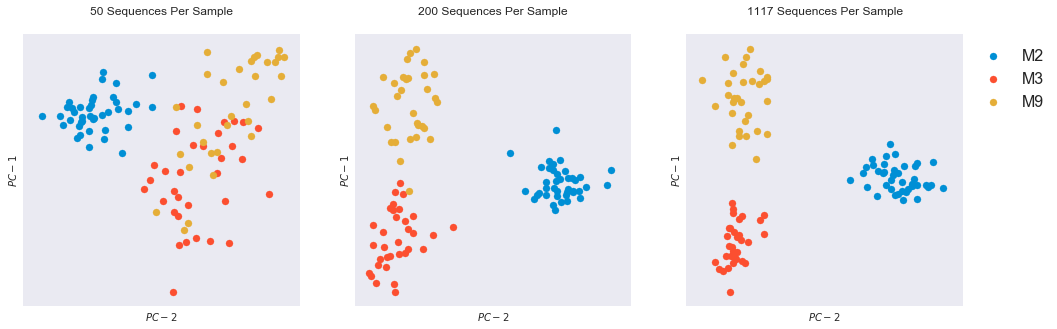

In [3]:
# sub sample 
Subsamples_noisy=[]
for sub_ in [50,200]:
      
    X_sub=otutabledf.T.fillna(0).astype(int).copy()
    #sub samples
    for column_ in X_sub.columns:
        X_sub[column_]=subsample_counts(X_sub[column_].values, sub_)

    Subsamples_noisy.append(X_sub)
    
Subsamples_noisy.append(otutabledf.T.fillna(0).astype(int).copy())
#plot data1
fig=plot_pcoa(Subsamples_noisy,mappingdf.T,'host_subject_id',method='jaccard')
plt.show()

#### Based on the Keyboard low rank dataset we can produce simulations 

Our goal here is to determine if our new tool, matrix completion, is useful compared to the state of the art which is psuedo counts. To do this robustly we will need to emulate the real data we just imported as closely as possible. To do this we can create a simulation to have a base truth (X) where:

Y = X + noise + sparsity

We can then compare X to psuedo counts and completion over several levels of sparsity.


In [4]:
# rank, homo, hesc, depth, intensity, num_samples, num_features, 
# overlap(input) , mapping(bool)


x0 = [3, .5, .5, 1e2, 1e2,1e1]
bnds = ((3,3),(0,1e2),(0,2e3),(0,1e10),(0,5e1),(1,10))
model_fit=minimize_model(x0,bnds,np.array(otutabledf.T[:104].T.as_matrix()))
print('Model Variables Fit:')
print(model_fit.x)

#Lets test the mean KL-divergence between the model and the real data 
base_truth,Truth_and_Noise,mapping=build_block_model(3, 1e1, 2e2, 1e+10, 5e1
                                                     ,otutabledf.shape[0]
                                                     ,otutabledf.shape[1],overlap=5)

base_truth=pd.DataFrame(base_truth,otutabledf.columns,otutabledf.index)
Truth_and_Noise=pd.DataFrame(Truth_and_Noise,otutabledf.columns,otutabledf.index)
print('Mean KL of Model to Real Data: '+str(np.mean(mean_KL((otutabledf.T+1)

                                                            , (Truth_and_Noise+1))))[:4])

Model Variables Fit:
[  3.           0.5          0.5        100.00000015  50.
  10.        ]
Mean KL of Model to Real Data: 0.95



We now have a model that emulates our real data set with a KL-divergence of 4.26. Just to make sure we are not fooling ourselves, we can plot these OTU tables as heatmaps and visually see how similar they are. We will also compare using PCoA as we did before.


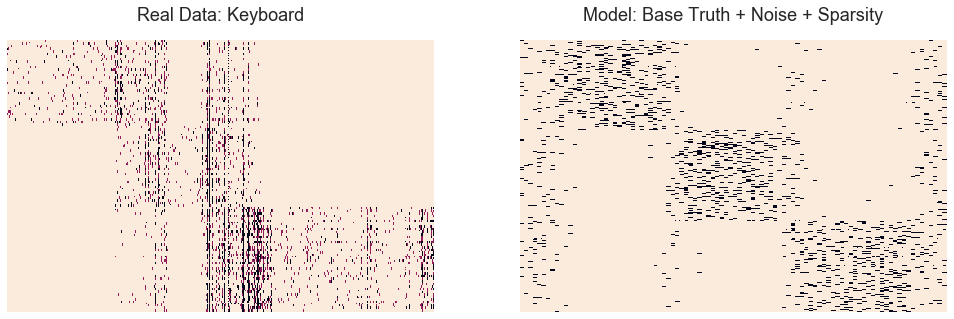

In [5]:
#run model on new for variables that we just learned from the fit smaller for easy running

base_truth,Truth_and_Noise,mapping=build_block_model(3, .1, .1, 1e2, 1e2,98
                                                     ,2688,overlap=10)

base_truth=pd.DataFrame(base_truth.T[:mapping.shape[0]].T,otutabledf.columns[:2688]
                        ,otutabledf.index[:mapping.shape[0]])

Truth_and_Noise=pd.DataFrame(Truth_and_Noise.T[:mapping.shape[0]].T,otutabledf.columns[:2688]
                             ,otutabledf.index[:mapping.shape[0]])


#compare the results as heatmaps
fig, axn = plt.subplots(ncols=2, nrows=1, figsize=(15, 5)) 
axs=axn.flat
sns.heatmap(np.log(otutabledf.as_matrix()+1),robust=True
            , xticklabels=False, yticklabels=False,ax=axs[0], cbar=False,cmap='rocket_r')
axs[0].set_title('Real Data: Keyboard',fontsize=18,y=1.05)

sns.heatmap(Truth_and_Noise.as_matrix(),robust=True
            , xticklabels=False, yticklabels=False,ax=axs[1], cbar=False,cmap='rocket_r')
axs[1].set_title('Model: Base Truth + Noise + Sparsity',fontsize=18,y=1.05)

plt.show()

These models look pretty close and good enough to do our benchmarking. We are going to use four different matrix completion methods as well as psuedo counts. Let's take a look in PCoA and see how this looks over different subsampling.

### Comparing the Model Over Rank (i.e. Number of Clusters) and Effect Size (i.e.  Sequencing depth and Cluster Overlap)

ow we can compare X to the different methods for producing a dense matrix (i.e. psuedo count vs. completion) through the mean Kullback-Leibler divergence for each method to X (our base truth) over many ranks (number of clusters) with the same sample by row dimensions. We will also compare this over sequencing depth and effect size by changing the amount of overlap between the clusters.


First we can visualize what this will look like with heat maps.

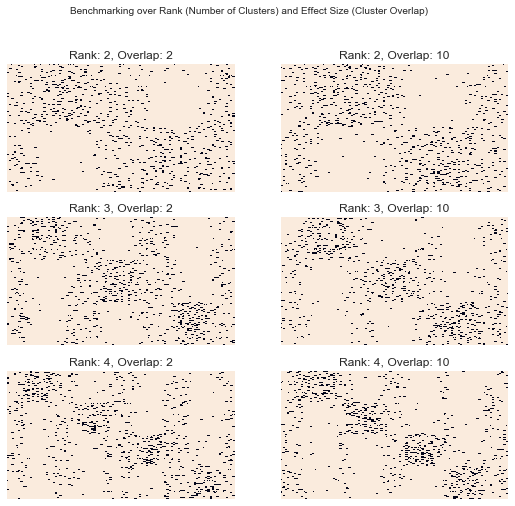

In [6]:
evaluate=[]

fig, axn = plt.subplots(3,2,figsize=(8,8))
for rank_,overlap_,ax_ in zip([2,2,3,3,4,4],
                             [2,10,2,10,2,10],axn.flat):
    
    #run model on new for variables that we just learned from the fit smaller for easy running
    base_truth,Truth_and_Noise=build_block_model(rank_, 1, .1, 1e2, 1e2
                                                 ,100,2500,overlap=overlap_,mapping_on=False,sigma=4)
    
    base_truth=pd.DataFrame(base_truth)
    X_noise_sparse=pd.DataFrame(Truth_and_Noise)
    
    sns.heatmap((Truth_and_Noise),robust=True
            , xticklabels=False, yticklabels=False,ax=ax_, cbar=False,cmap='rocket_r')
    ax_.set_title('Rank: '+str(rank_)+', Overlap: '+str(overlap_),fontsize=12)
        
plt.suptitle('Benchmarking over Rank (Number of Clusters) and Effect Size (Cluster Overlap)',fontsize=10)   
plt.show()

Now we will run this over all the above examples with different sequencing depths. 

** Warning (this takes a long time to run) ** 

In [10]:
%%capture capt
mse=[]
method=[]
ranks=[]
effects=[]
num_seq=[]

for rank_,overlap_ in zip([2,2,3,3,4,4],
                             [2,10,2,10,2,10]):
    
    #subsample_points=np.logspace(2,4,4)
    seq_depth={100:2e2,1000:1e3,2000:2e3,5000:5e3,10000:1e4}
    
    # sub sample 
    for sub_,model_peram in seq_depth.items():
        
        base_truth,X_noise_sub=build_block_model(rank_,  .1, .1, model_peram, model_peram
                                                 ,100,2500,overlap=overlap_
                                                 ,mapping_on=False)
        base_truth=pd.DataFrame(base_truth)

            
        X_rcovered_methods_sigmas={'Pseudo Count':[],'OptSpace':[]
                                   ,'Soft Impute':[],'KNN':[]
                                   ,'Iterative SVD':[]}


        #for X_noise_subsampled in Subsamples_noisy:
        X_noise_subsampled=pd.DataFrame(X_noise_sub)
        

        #psuedo count
        X_rcovered_methods_sigmas['Pseudo Count'].append(pd.DataFrame(X_noise_subsampled+1
                                                               ,X_noise_subsampled.index
                                                               ,X_noise_subsampled.columns))

        # OptSpace
        X_filled_opt=OptSpace(X_noise_subsampled.as_matrix().copy(),rank=rank_
                              ,minval=.1,maxval=10,clip_high=False).complete()
        X_rcovered_methods_sigmas['OptSpace'].append(pd.DataFrame(X_filled_opt
                                                           ,X_noise_subsampled.index,
                                                           X_noise_subsampled.columns))

        # Make 0 NaN for fancy impute 
        X_noisefancy=X_noise_subsampled.copy()
        X_noisefancy[X_noisefancy==0]=np.nan

        # KNN
        X_filled_knn = KNN(verbose=False,max_value=10,min_value=.1).complete(X_noisefancy)
        X_rcovered_methods_sigmas['KNN'].append(pd.DataFrame(X_filled_knn,X_noise_subsampled.index
                                                      ,X_noise_subsampled.columns))

        #soft impute
        X_filled_softimpute = SoftImpute(verbose=False,max_value=10,min_value=.1).complete(X_noisefancy)
        X_rcovered_methods_sigmas['Soft Impute'].append(pd.DataFrame(X_filled_softimpute
                                                              ,X_noise_subsampled.index
                                                              ,X_noise_subsampled.columns))

        # Iter SVD
        X_filled_iter=IterativeSVD(verbose=False,max_value=10,min_value=.1).complete(X_noisefancy)
        X_rcovered_methods_sigmas['Iterative SVD'].append(pd.DataFrame(X_filled_iter
                                                                ,X_noise_subsampled.index
                                                                ,X_noise_subsampled.columns))

        #MSE
        for mthod_,X_recovered_on_sigma in X_rcovered_methods_sigmas.items():
            X_recovered_on_sigma=X_recovered_on_sigma[0]
            kl_=mean_KL((base_truth), (X_recovered_on_sigma))
            
            #kl_=[mean_squared_error(base_truth, X_recovered_on_sigma)]
            
            mse+=kl_
            method+=[mthod_]*len(kl_)
            ranks+=[rank_]*len(kl_)
            effects+=[overlap_]*len(kl_)
            num_seq+=[sub_]*len(kl_)

In [11]:
save_all=pd.DataFrame([mse,method,ranks,effects,num_seq],['Mean KL','Method','Number of Clusters','Overlap','Sequences Per Sample']).T
save_all=save_all.apply(pd.to_numeric, errors='ignore')
#Save the data to a file 
#save_all.to_csv('/Users/cameronmartino/bin/tmp/DEICODE/Examples/output/lowrank_bench.csv')


Now we can look at our saved data table or plot the results to visually see how this is working.

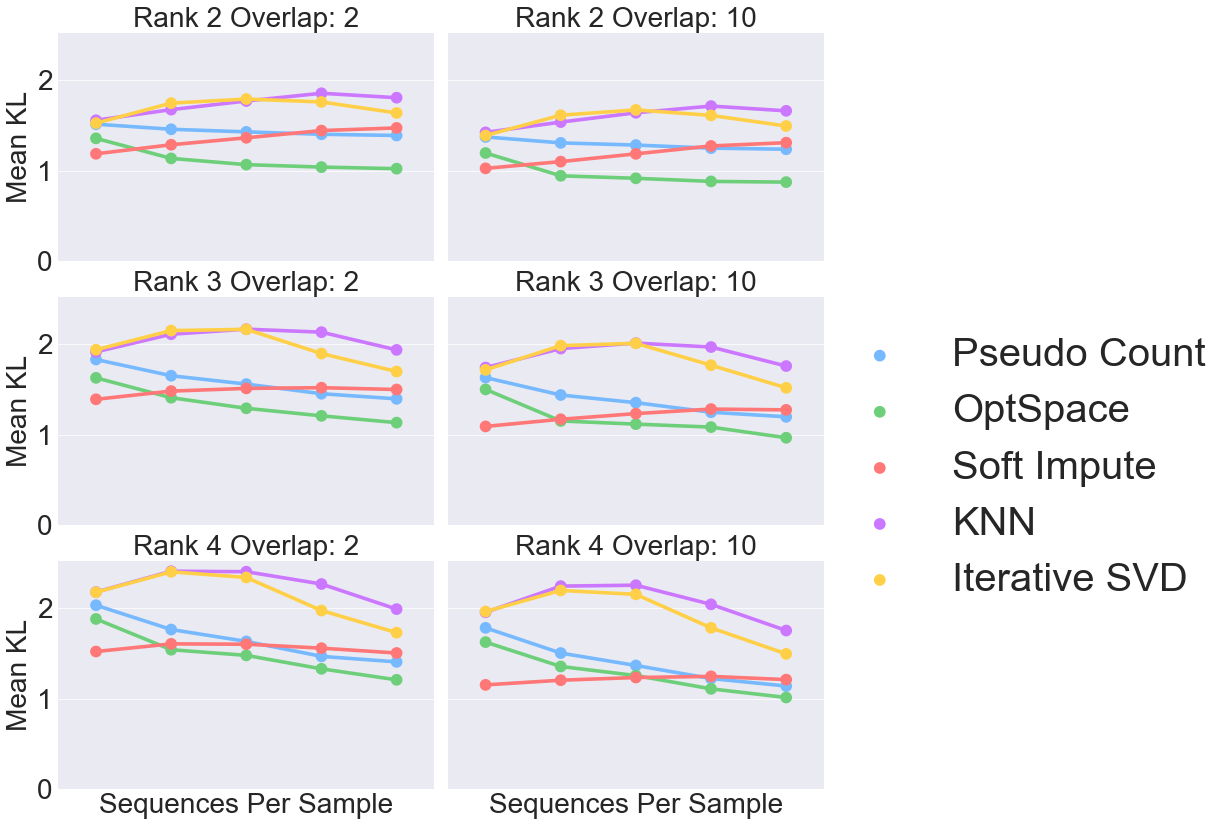

In [12]:
save_all['Group']="Rank "+save_all['Number of Clusters'].astype(str)+" Overlap: "+save_all['Overlap'].astype(str)
paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc)  
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["axes.labelsize"] = 28
plt.rcParams['xtick.labelsize'] = 28
plt.rcParams['ytick.labelsize'] = 28

palette_map={'Soft Impute': '#FF7777',
                'KNN': '#CB77FF',
                'Pseudo Count': '#77B9FF',
                'OptSpace': '#6ECF7A',
                'Iterative SVD': '#FFD047'}

g=sns.factorplot(x="Sequences Per Sample", y="Mean KL", hue="Method", col="Group"
               , data=save_all,
                   sharex=True, sharey=True,col_wrap=2,palette=palette_map
               , aspect=1.5,legend=False, kind="point")

g.set_titles("{col_name}")
plt.legend(bbox_to_anchor=(1.0, 2.05), loc=2, borderaxespad=0.,prop={'size':40})
loc, labels = plt.xticks()
labels=['%s'%str(x.get_text()).split('.')[0] for x in labels]
plt.xticks(loc[::3],labels[::3])
plt.xticks([0,1,2,3,4],labels)
plt.xticks([])
plt.ylim(0,)
plt.show()